<a href="https://colab.research.google.com/github/slayerzeroa/WVKOSPI/blob/master/VKOSPI_240104.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install pykrx --q
%pip install pandas_datareader --q
%pip install pyfolio-reloaded --q

In [ ]:
import pandas as pd
import numpy as np
import math
from datetime import datetime, timedelta

from scipy import interpolate

from pandas import DataFrame, Series
import requests as re
from bs4 import BeautifulSoup
from pykrx import stock
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt

from pandas_datareader import data
import yfinance as yf
yf.pdr_override()

import pyfolio as pf

In [ ]:
# 금리 데이터 크롤링 함수
def crawling_interest_rates():
    data_dict = {'IRR_CD91':[],
                 'IRR_CALL':[]}
    label_list = ['IRR_CD91','IRR_CALL']
    Data = DataFrame()
    for label in label_list:
        date_list = []
        try:
            for i in range(1, 40):
                url = re.get('http://finance.naver.com/marketindex/interestDailyQuote.nhn?marketindexCd=%s&page=%s'%(label,i))
                url = url.content
                soup = BeautifulSoup(url,'html.parser')

                # 날짜 가져오기
                dates = soup.select('tr > td.date')

                try:
                    test = soup.find('tbody').find('tr').find('td',{'class':'num'}).text # .text가 에러를 반환하는가?
                except:
                    break

                for date in dates:
                    date_list.append(date.text.strip())

                rates = soup.find('tbody').find_all('tr')
                for rate in rates:
                    data_dict[label].append(rate.find('td',{'class':'num'}).text.strip())

        except:
            print('Error')

        temp_dataframe = DataFrame(data_dict[label], index = date_list)
        Data = pd.merge(Data,temp_dataframe,how = 'outer', left_index = True, right_index = True)

    Data.columns = ['CD91일', '콜금리']

    Data.index = pd.to_datetime(Data.index)
    return Data

In [ ]:
# 금리 interpolation 함수
def rf_inter(mydate:datetime ,near_date_diff, next_date_diff, df):
    # 금리 interpolation
    my_data = df[df.index==mydate]
    x = [1, 91]
    y = [float(my_data['콜금리']), float(my_data['CD91일'])]

    spline_func = interpolate.CubicSpline(x, y)

    y1 = float(spline_func(near_date_diff)) / (60*24*365)
    y2 = float(spline_func(next_date_diff) / (60*24*365))
    return [y1, y2]

In [ ]:
# rate_df = crawling_interest_rates()

Error


In [ ]:
# rate_df.to_csv('rate_df.csv')

In [ ]:
rate_df = pd.read_csv('rf_rate.csv', index_col=0)
rate_df
rate_df.index = pd.to_datetime(rate_df.index)

In [ ]:
# 매주 옵션 만기일
# 월요일은 0, 목요일은 3
def nth_weekday(the_date, week_day):
    the_date += timedelta(days=1)
    while the_date.weekday() != week_day:
        the_date += timedelta(days=1)
    return the_date

# 근주물 옵션 만기일 구하기
def get_near_due(mydate:datetime)->datetime:
    # 목요일이 near term
    duedate_t = [0, 1, 2]
    # 월요일이 near term
    duedate_m = [3, 4, 5, 6]

    if mydate.weekday() in duedate_t:
      thisweek_duedate = nth_weekday(mydate, 3)
    else:
      thisweek_duedate = nth_weekday(mydate, 0)

    return thisweek_duedate

# 원주물 옵션 만기일 구하기
def get_next_due(mydate:datetime)->datetime:
    # 목요일이 near term
    duedate_t = [0, 1, 2]
    # 월요일이 near term
    duedate_m = [3, 4, 5, 6]

    if mydate.weekday() in duedate_m:
      mydate += timedelta(days=4)
      thisweek_duedate = nth_weekday(mydate, 3)
    else:
      mydate += timedelta(days=4)
      thisweek_duedate = nth_weekday(mydate, 0)

    return thisweek_duedate


# 날짜 차이 구하기
def date_diff(now, future):
  gap = future - now
  return gap.days

In [ ]:
# following_two_cutoff 함수
def following_two_cutoff(data: pd.DataFrame):
  filter = data['Strike_Price_Diff'] < 7.5
  filter = list(filter)
  center = int(len(filter) / 2)
  flag = True
  while center != 0:
    if filter[center] == False:
      filter[center] = flag
      flag = False
    else:
      filter[center] = flag
    center -= 1

  center = int(len(filter) / 2)
  flag = True
  while center != (len(filter)-1):
    if filter[center] == False:
      flag = False
    filter[center] = flag
    center += 1

  return filter

# Cutoff 함수
def cutoff(data: pd.DataFrame, underlying):
  if data['Option_Type'].unique() == 'C':
    data_cutoff = data[following_two_cutoff(data)]
    data_cutoff = data_cutoff[data_cutoff['Strike_Price'].astype(float) > underlying]
  if data['Option_Type'].unique() == 'P':
    data_cutoff = data[following_two_cutoff(data)]
    data_cutoff = data_cutoff[data_cutoff['Strike_Price'].astype(float) < underlying]
  return data_cutoff

In [ ]:
def cal_vix(t: datetime, rate_df: pd.DataFrame):
  # try:
    # 기초자산 가격
    # kospi 200
    df = stock.get_index_ohlcv_by_date(t, t, "1028")
    underlying = (float(df.종가))

    # 목요일 만기 위클리 옵션 데이터
    option_data_t = stock.get_future_ohlcv(t, 'KRDRVOPWKI')

    # 월요일 만기 위클리 옵션 데이터
    option_data_m = stock.get_future_ohlcv(t, 'KRDRVOPWKM')

    option_data_t.dropna(axis = 1, how='all', inplace=True)
    option_data_t.dropna(axis = 0, how='any', inplace=True)
    option_data_m.dropna(axis = 1, how='all', inplace=True)
    option_data_m.dropna(axis = 0, how='any', inplace=True)

    near_date = get_near_due(t)
    next_date = get_next_due(t)

    near_date_diff = date_diff(t, near_date)
    next_date_diff = date_diff(t, next_date)

    rates = rf_inter(t, near_date_diff, next_date_diff, rate_df)

    Nt=[60*24*near_date_diff, 60*24*next_date_diff]		#minutes
    T=[Nt[0]/(60*24*365), Nt[1]/(60*24*365)]	#years

    if near_date.weekday() == 0:
      near_option_data = option_data_m
      next_option_data = option_data_t
    else:
      near_option_data = option_data_t
      next_option_data = option_data_m

    near_term_option = pd.DataFrame()

    near_option_data['Strike_Price'] = near_option_data['종목명'].str[-5:]
    near_option_data['Option_Type'] = near_option_data['종목명'].str[-14]

    near_data = []
    for i in near_option_data.Strike_Price:
      check = near_option_data[near_option_data.Strike_Price == i]
      if len(check) == 2:
        input_data = []
        # [Strike Price, Call Close, Put Close, Difference]
        input_data.append(float(check['Strike_Price'].unique()))
        input_data.append(check['종가'].to_list()[0])
        input_data.append(check['종가'].to_list()[1])
        input_data.append(abs(check['종가'].to_list()[0]-check['종가'].to_list()[1]))
        if input_data not in near_data:
          near_data.append(input_data)
      else:
        pass

    near_term_option = pd.concat([near_term_option, pd.DataFrame(near_data)])
    near_term_option.columns = ['Strike_Price', 'Call', 'Put', 'Difference']
    near_term_option = near_term_option[(near_term_option['Call']!=0) & (near_term_option['Put']!=0)]

    next_term_option = pd.DataFrame()

    next_option_data['Strike_Price'] = next_option_data['종목명'].str[-5:]
    next_option_data['Option_Type'] = next_option_data['종목명'].str[-14]

    # 월, 목 옵션 동시 존재 에러 해결
    # 예시) 월요일에는 월요일 만기 옵션이 두 종류 존재 (오늘 만기, 다음주 만기)
    # 다음주 만기 옵션 데이터만 남기기 (롤오버)
    next_option_data['Select'] = (next_option_data['종목명'].str[-13:-8] + next_option_data['종목명'].str[-7:-6]).astype(int)
    next_option_data = next_option_data[next_option_data['Select'] == next_option_data['Select'].max()]

    next_data = []
    for i in next_option_data.Strike_Price:
      check = next_option_data[next_option_data.Strike_Price == i]
      if len(check) == 2:
        input_data = []
        # [Strike Price, Call Close, Put Close, Difference]
        input_data.append(float(check['Strike_Price'].unique()))
        input_data.append(check['종가'].to_list()[0])
        input_data.append(check['종가'].to_list()[1])
        input_data.append(abs(check['종가'].to_list()[0]-check['종가'].to_list()[1]))
        if input_data not in next_data:
          next_data.append(input_data)
      else:
        pass

    next_term_option = pd.concat([next_term_option, pd.DataFrame(next_data)])
    next_term_option.columns = ['Strike_Price', 'Call', 'Put', 'Difference']
    next_term_option = next_term_option[(next_term_option['Call']!=0) & (next_term_option['Put']!=0)]

    F1_data = near_term_option[near_term_option['Difference'] == near_term_option['Difference'].min()]
    F2_data = next_term_option[next_term_option['Difference'] == next_term_option['Difference'].min()]

    F1 = float(F1_data['Strike_Price'] + math.exp(rates[0] * T[0]) * (F1_data['Call'] - F1_data['Put']))
    F2 = float(F2_data['Strike_Price'] + math.exp(rates[1] * T[1]) * (F2_data['Call'] - F2_data['Put']))

    K_0_1 = near_term_option[(near_term_option['Strike_Price'].astype(float) - F1 < 1)].Difference == near_term_option[(near_term_option['Strike_Price'].astype(float) - F1 < 1)].Difference.min()
    K_0_1 = float(near_term_option[(near_term_option['Strike_Price'].astype(float) - F1 < 1)][K_0_1].Strike_Price)
    K_0_2 = next_term_option[(next_term_option['Strike_Price'].astype(float) - F2 < 1)].Difference == next_term_option[(next_term_option['Strike_Price'].astype(float) - F2 < 1)].Difference.min()
    K_0_2 = float(next_term_option[(next_term_option['Strike_Price'].astype(float) - F2 < 1)][K_0_2].Strike_Price)

    near_option_data_call = near_option_data[near_option_data['Option_Type'] == 'C']
    near_option_data_put = near_option_data[near_option_data['Option_Type'] == 'P']
    next_option_data_call = next_option_data[next_option_data['Option_Type'] == 'C']
    next_option_data_put = next_option_data[next_option_data['Option_Type'] == 'P']

    near_option_data_call['Strike_Price_Diff'] = near_option_data_call['Strike_Price'].astype(float).diff()
    near_option_data_put['Strike_Price_Diff'] = near_option_data_put['Strike_Price'].astype(float).diff()
    next_option_data_call['Strike_Price_Diff'] = next_option_data_call['Strike_Price'].astype(float).diff()
    next_option_data_put['Strike_Price_Diff'] = next_option_data_put['Strike_Price'].astype(float).diff()

    near_call = cutoff(near_option_data_call, underlying)
    near_put = cutoff(near_option_data_put, underlying)
    next_call = cutoff(next_option_data_call, underlying)
    next_put = cutoff(next_option_data_put, underlying)
    near_call['Contribution_by_Strike'] = (2.5/(near_call['Strike_Price'].astype(float).pow(2))) * math.exp(rates[0] * T[0]) * near_call['종가']
    near_put['Contribution_by_Strike'] = (2.5/(near_put['Strike_Price'].astype(float).pow(2))) * math.exp(rates[0] * T[0]) * near_put['종가']
    next_call['Contribution_by_Strike'] = (2.5/(next_call['Strike_Price'].astype(float).pow(2))) * math.exp(rates[1] * T[1]) * next_call['종가']
    next_put['Contribution_by_Strike'] = (2.5/(next_put['Strike_Price'].astype(float).pow(2))) * math.exp(rates[1] * T[1]) * next_put['종가']
    near = pd.concat([near_call, near_put])
    next = pd.concat([next_call, next_put])
    sigmasquared_1 = (2/T[0])*near['Contribution_by_Strike'].sum() - (1/T[0])*((F1/K_0_1)-1)**2
    sigmasquared_2 = (2/T[1])*next['Contribution_by_Strike'].sum() - (1/T[1])*((F2/K_0_2)-1)**2
    N30 = 60*24*5
    N365 = 60*24*365
    VIX = 100 * np.sqrt((T[0]*sigmasquared_1*((Nt[1]-N30)/(Nt[1]-Nt[0]))+T[1]*sigmasquared_2*((N30-Nt[0])/(Nt[1]-Nt[0])))*(N365/N30))
    return VIX
  # except Exception as e:
  #   print('Error')
  #   print(e)
  #   return None

In [ ]:
# t = '20231201'
# t = datetime.strptime(t, '%Y%m%d')

# vix = cal_vix(t, rate_df)
# vix

In [ ]:
import warnings

# 오류 경고 무시하기
warnings.filterwarnings(action='ignore')


vix_list = []
date_list = []
t = '20230720'
t = datetime.strptime(t, '%Y%m%d')
for i in range(200):
  try:
    vix = cal_vix(t, rate_df)
    vix_list.append(vix)
    date_list.append(t)
    t += timedelta(days=1)
  except:
    t += timedelta(days=1)

vix_df = pd.DataFrame([date_list, vix_list]).T
vix_df.columns = ['Date', 'w_vix']


In [ ]:
vix_df.to_csv('w_vix.csv', index=False)

In [ ]:
vix_df = pd.read_csv("w_vix.csv")
vix_df = vix_df.set_index('Date')
vix_df.index = pd.to_datetime(vix_df.index)
vix_df.columns = ['w_vix']
vix_df

w_vix
Date                 
2023-08-01  12.981608
2023-08-02  14.502985
2023-08-03  10.554583
2023-08-10  13.070633
2023-08-11  11.267328
...               ...
2023-11-22  13.930290
2023-11-23  12.802447
2023-11-24  13.134453
2023-11-27  14.956412
2023-11-28  14.302280

[64 rows x 1 columns]

In [ ]:
date_list = list(vix_df.index)
monthly_vix_list = []
for date in date_list:
  monthly_vix_list.append(stock.get_future_ohlcv(date, 'KRDRVFUVKI')['현물가'][0])

In [ ]:
vix_df['vix'] = monthly_vix_list

In [ ]:
df_1 = pd.read_csv('KRX_Dataset.csv')
df_1 = df_1.set_index('Date')
df_1

w_vix    vix        kospi  w_vix_returns  vix_returns  \
Date                                                                    
2023-08-01  12.981608  14.05  2667.070068      -0.080053    -0.017483   
2023-08-02  14.502985  15.00  2616.469971       0.117195     0.067616   
2023-08-03  10.554583  15.80  2605.389893      -0.272248     0.053333   
2023-08-10  13.070633  13.90  2601.560059       0.238385    -0.120253   
2023-08-11  11.267328  13.60  2591.260010      -0.137966    -0.021583   
...               ...    ...          ...            ...          ...   
2023-12-21  13.880854  15.25  2600.020020       0.006594     0.013289   
2023-12-22  13.058856  15.30  2599.510010      -0.059218     0.003279   
2023-12-26  16.265063  15.75  2602.590088       0.245520     0.029412   
2023-12-27  15.542965  16.50  2613.500000      -0.044396     0.047619   
2023-12-28  15.960413  17.30  2655.280029       0.026858     0.048485   

            kospi_returns  CD91일   콜금리  
Date                                    
2023-08-01       0.013101   3.74  3.45  
2023-08-02      -0.018972   3.74  3.43  
2023-08-03      -0.004235   3.73  3.45  
2023-08-10      -0.001470   3.68  3.59  
2023-08-11      -0.003959   3.69  3.57  
...                   ...    ...   ...  
2023-12-21      -0.005462   3.83  3.62  
2023-12-22      -0.000196   3.83  3.63  
2023-12-26       0.001185   3.83  3.63  
2023-12-27       0.004192   3.83  3.55  
2023-12-28       0.015986   3.83  3.60  

[81 rows x 8 columns]

In [ ]:
import copy
df = data.get_data_yahoo('^KS200')
ks200 = copy.deepcopy(df[['Adj Close']])
ks200.columns = ['kospi200']
ks200['kospi200_returns'] = ks200['kospi200'].pct_change()
df_1.index = pd.to_datetime(df_1.index)
df = pd.merge(
    df_1, ks200, how="left", left_index=True, right_index=True
    )

df = df[['w_vix', 'vix', 'kospi', 'kospi200', 'w_vix_returns', 'vix_returns', 'kospi_returns', 'kospi200_returns', 'CD91일', '콜금리']]
df

df.to_csv("KRX_Dataset.csv", index=True)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
df = data.get_data_yahoo('^KS200')

df = pd.merge(
    vix_df, df['Adj Close'], how="left", left_index=True, right_index=True
    )
df.columns = ['w_vix', 'vix', 'kospi']

df['w_vix_returns'] = df['w_vix'].pct_change()
df['vix_returns'] = df['vix'].pct_change()
df['kospi_returns'] = df['kospi'].pct_change()

df = df.dropna()

[*********************100%%**********************]  1 of 1 completed


NameError: name 'vix_df' is not defined

In [ ]:
df = pd.merge(df, rate_df, how="left", left_index=True, right_index=True)

In [ ]:
# df[df.index <= '2023-12-28'].to_csv('KRX_Dataset.csv')

In [ ]:
df = pd.read_csv("KRX_Dataset.csv")
df = df.set_index('Date')
df

w_vix    vix        kospi  w_vix_returns  vix_returns  \
Date                                                                    
2023-08-01  12.981608  14.05  2667.070068      -0.080053    -0.017483   
2023-08-02  14.502985  15.00  2616.469971       0.117195     0.067616   
2023-08-03  10.554583  15.80  2605.389893      -0.272248     0.053333   
2023-08-10  13.070633  13.90  2601.560059       0.238385    -0.120253   
2023-08-11  11.267328  13.60  2591.260010      -0.137966    -0.021583   
...               ...    ...          ...            ...          ...   
2023-12-21  13.880854  15.25  2600.020020       0.006594     0.013289   
2023-12-22  13.058856  15.30  2599.510010      -0.059218     0.003279   
2023-12-26  16.265063  15.75  2602.590088       0.245520     0.029412   
2023-12-27  15.542965  16.50  2613.500000      -0.044396     0.047619   
2023-12-28  15.960413  17.30  2655.280029       0.026858     0.048485   

            kospi_returns  CD91일   콜금리  
Date                                    
2023-08-01       0.013101   3.74  3.45  
2023-08-02      -0.018972   3.74  3.43  
2023-08-03      -0.004235   3.73  3.45  
2023-08-10      -0.001470   3.68  3.59  
2023-08-11      -0.003959   3.69  3.57  
...                   ...    ...   ...  
2023-12-21      -0.005462   3.83  3.62  
2023-12-22      -0.000196   3.83  3.63  
2023-12-26       0.001185   3.83  3.63  
2023-12-27       0.004192   3.83  3.55  
2023-12-28       0.015986   3.83  3.60  

[81 rows x 8 columns]

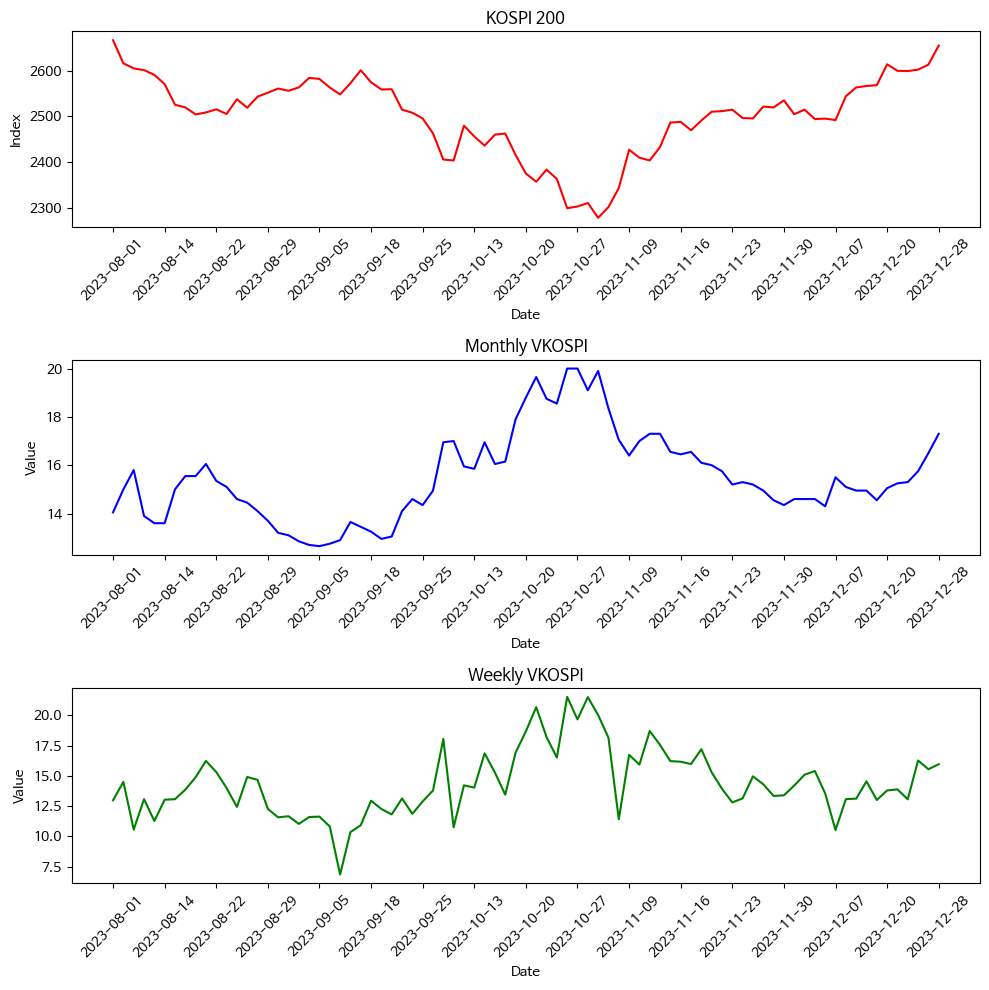

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
fig.tight_layout()

#define data

#create subplots
ax[0].plot(df.index, df['kospi'], color='red')
ax[0].set_title('KOSPI 200')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Index')
ax[0].set_xticks(ticks=df.index, labels=df.index, rotation=45)
ax[0].locator_params(axis='x', nbins=20)

ax[1].plot(df.index, df['vix'], color='blue')
ax[1].set_title('Monthly VKOSPI')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Value')
ax[1].set_xticks(ticks=df.index, labels=df.index, rotation=45)
ax[1].locator_params(axis='x', nbins=20)

ax[2].plot(df.index, df['w_vix'], color='green')
ax[2].set_title('Weekly VKOSPI')
ax[2].set_xlabel('Date')
ax[2].set_ylabel('Value')
ax[2].set_xticks(ticks=df.index, labels=df.index, rotation=45)
ax[2].locator_params(axis='x', nbins=20)

plt.tight_layout()

plt.show()

In [ ]:
# df = df[df.index <= '2023-12-28']
df
df.index = pd.to_datetime(df.index)


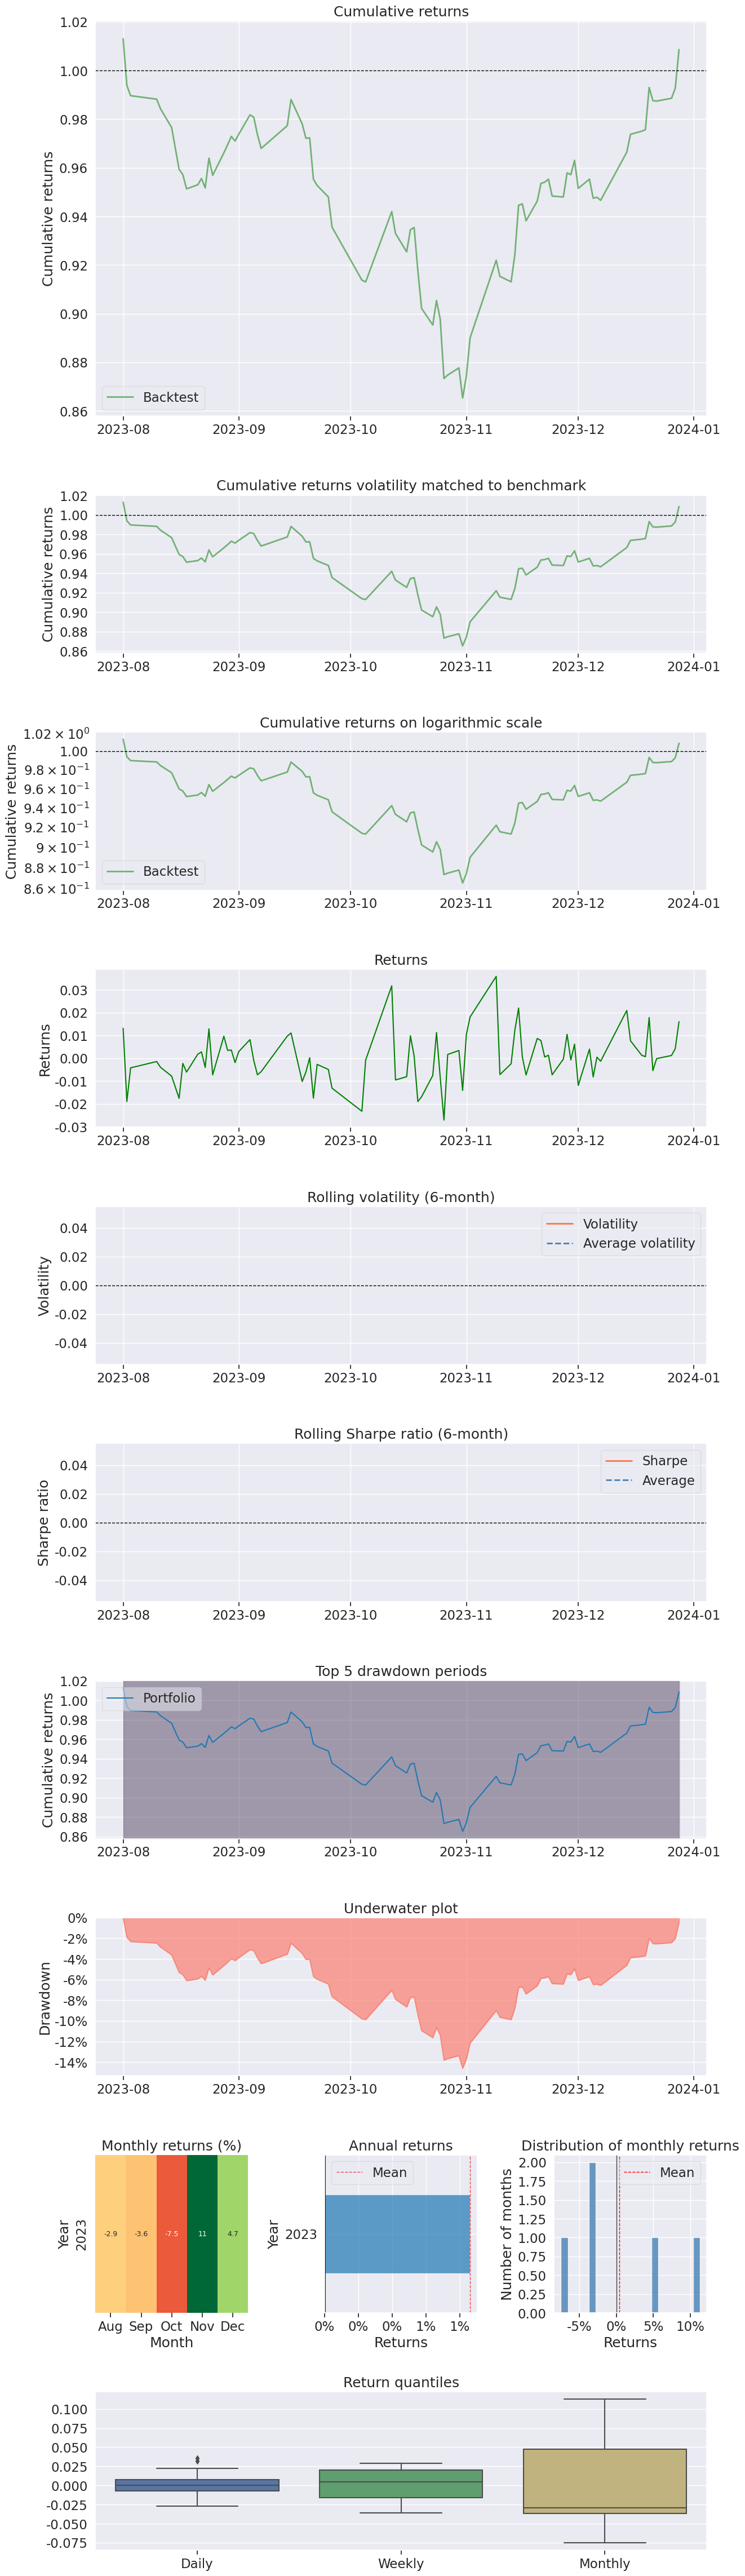

In [ ]:
returns = df[['kospi_returns', 'w_vix_returns', 'vix_returns']]

# returns
portfolio_weights = [1.0, 0.0, 0.0]

portfolio_returns = pd.Series(np.dot(portfolio_weights, returns.T),
                              index=df.index)

pf.create_returns_tear_sheet(returns=portfolio_returns)

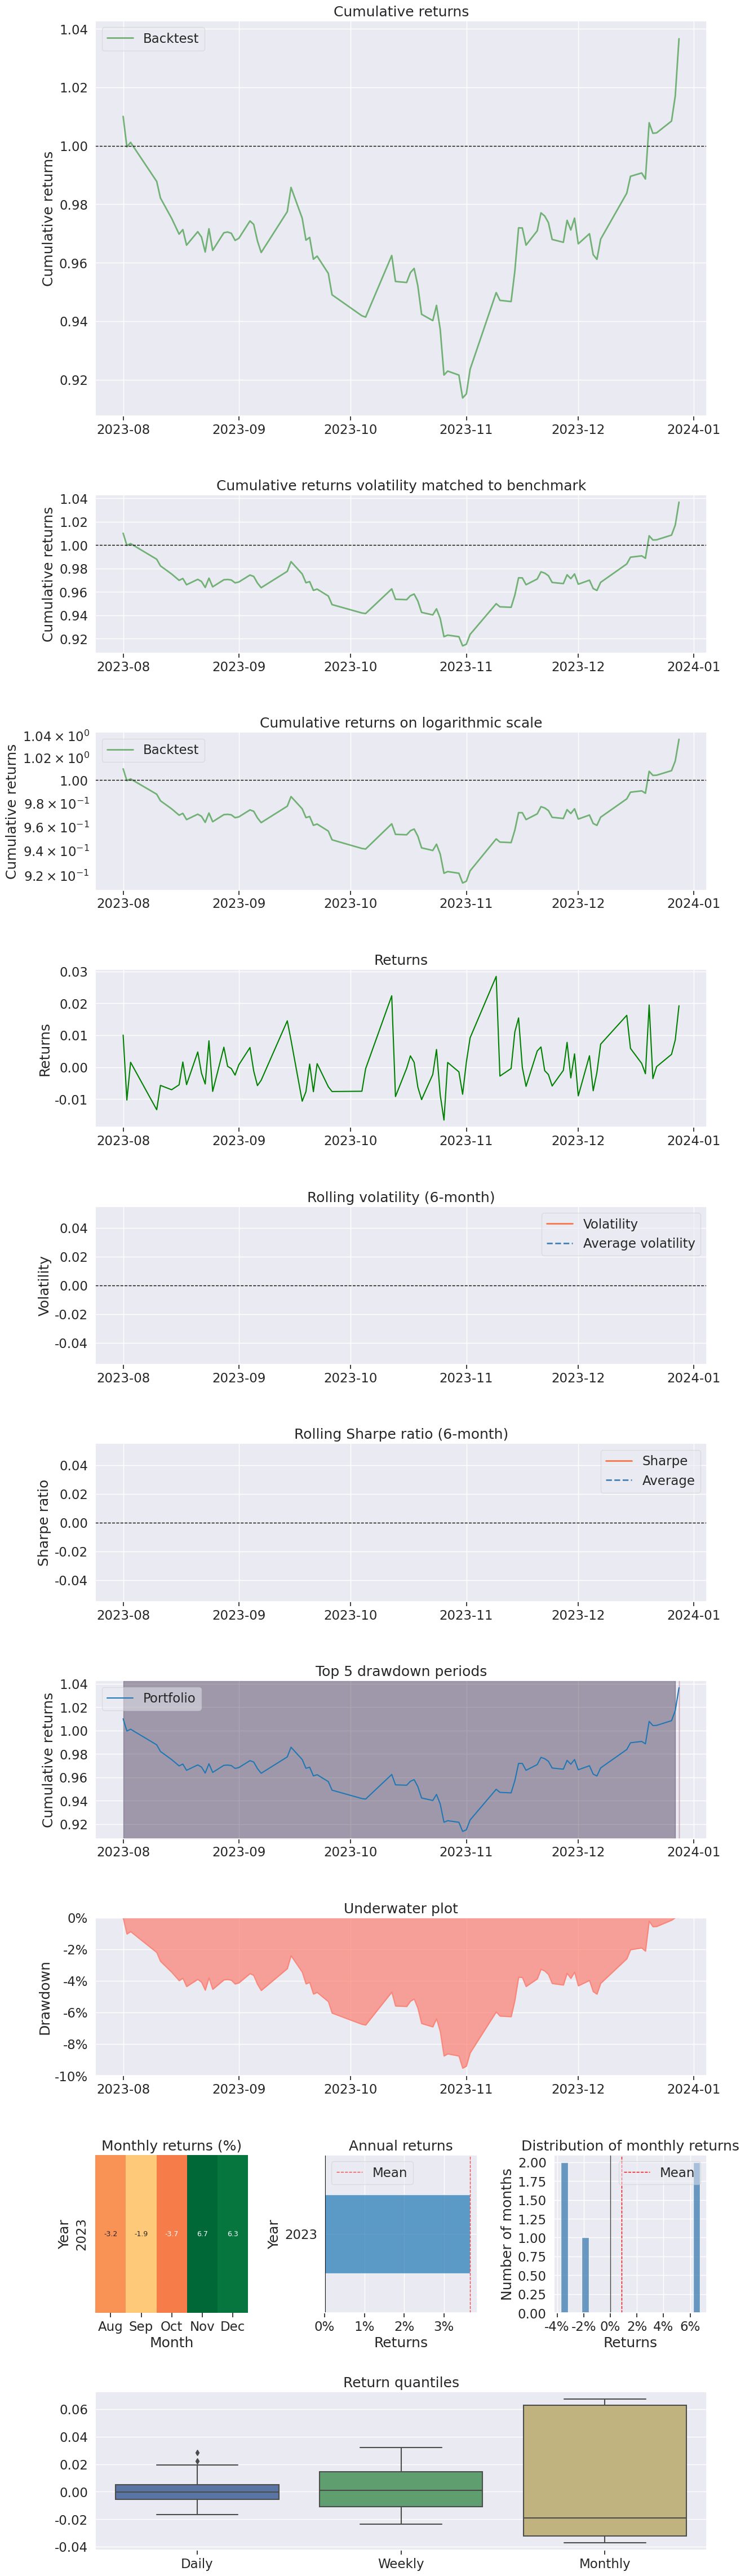

In [ ]:
returns = df[['kospi_returns', 'w_vix_returns', 'vix_returns']]
portfolio_weights = [0.9, 0.0, 0.1]

portfolio_returns = pd.Series(np.dot(portfolio_weights, returns.T),
                              index=df.index)

pf.create_returns_tear_sheet(returns=portfolio_returns)

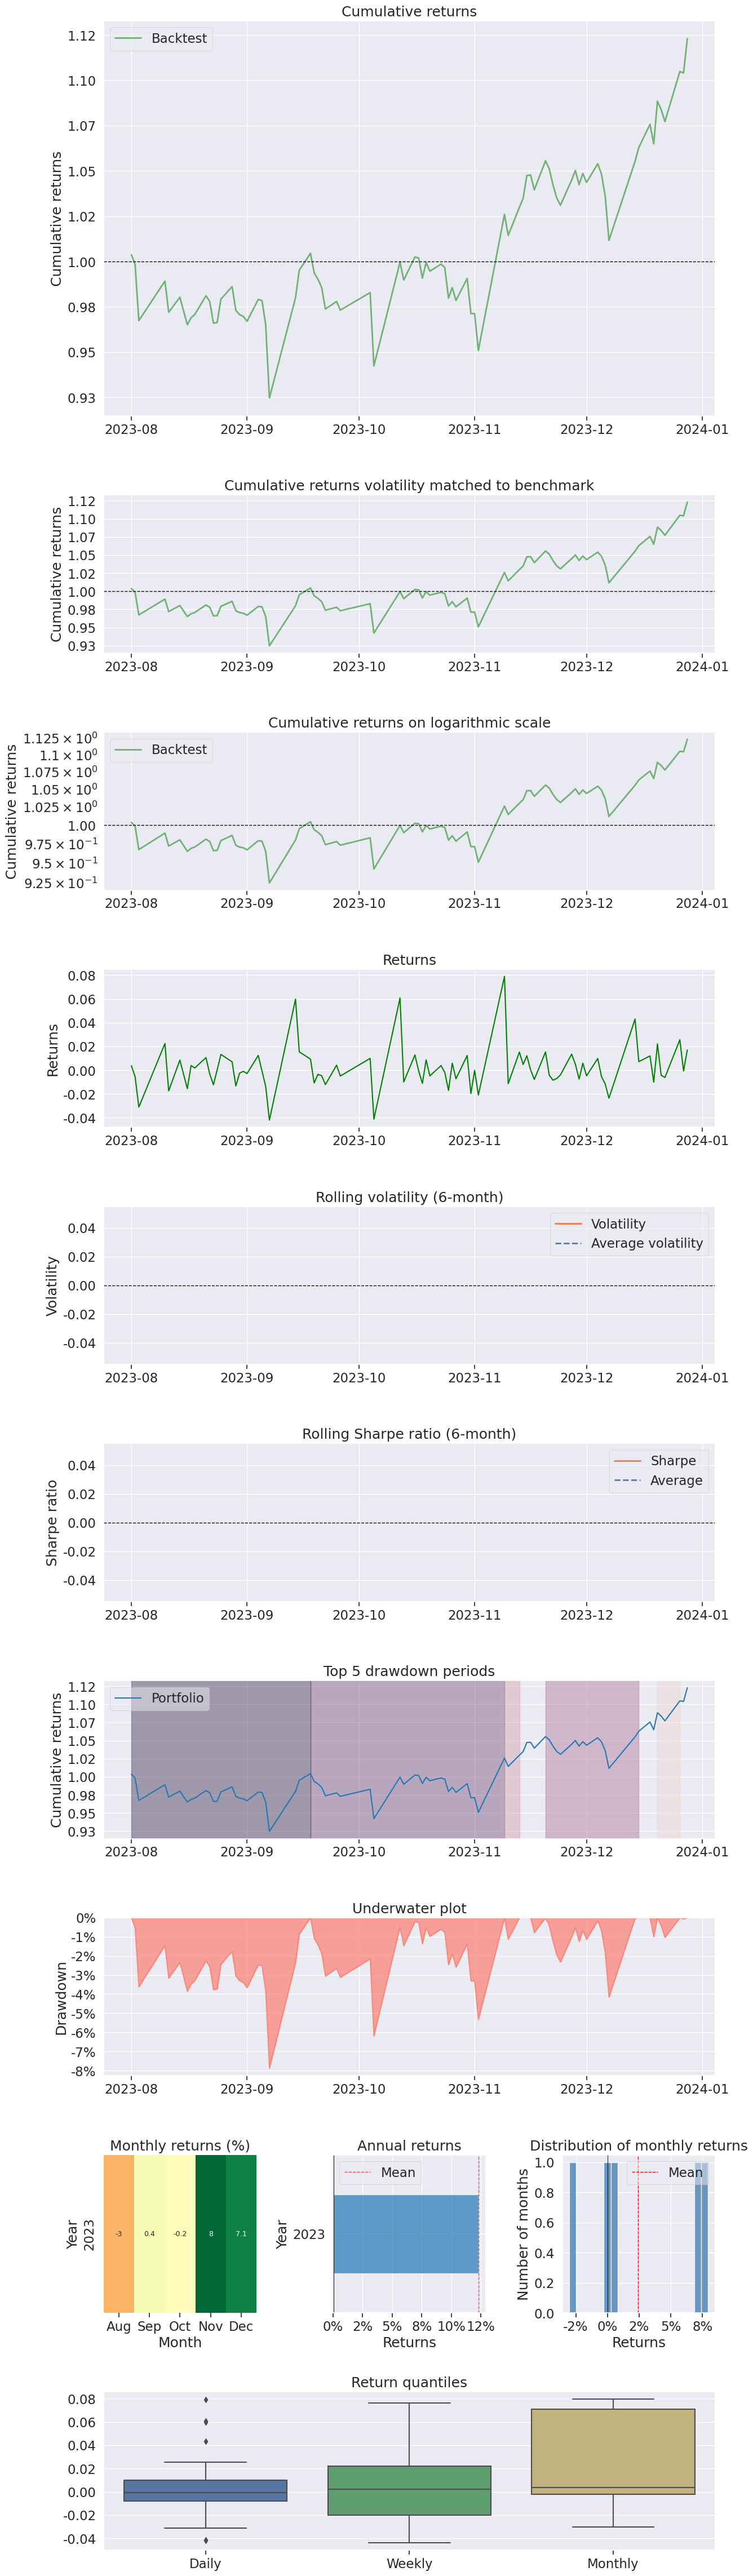

In [ ]:
returns = df[['kospi_returns', 'w_vix_returns', 'vix_returns']]
portfolio_weights = [0.9, 0.1, 0.0]

portfolio_returns = pd.Series(np.dot(portfolio_weights, returns.T),
                              index=df.index)

pf.create_returns_tear_sheet(returns=portfolio_returns)


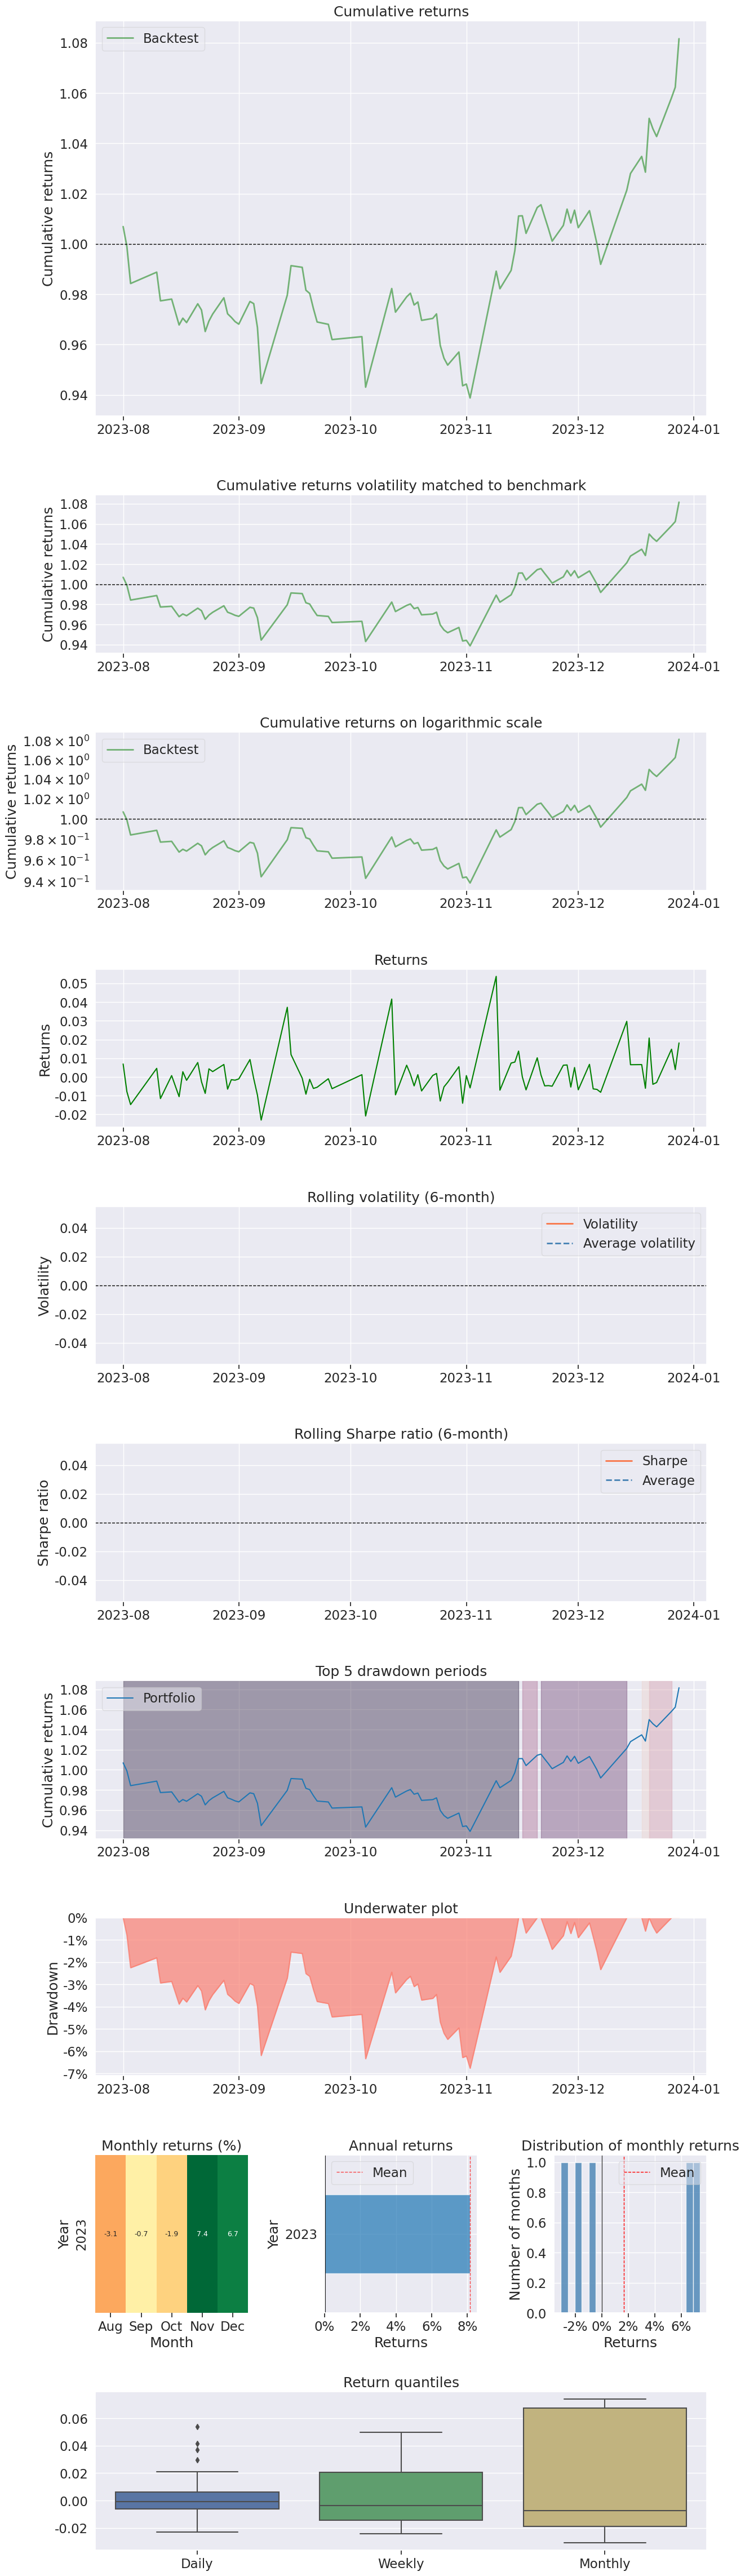

In [ ]:
returns = df[['kospi_returns', 'w_vix_returns', 'vix_returns']]
portfolio_weights = [0.9, 0.05, 0.05]

portfolio_returns = pd.Series(np.dot(portfolio_weights, returns.T),
                              index=df.index)

pf.create_returns_tear_sheet(returns=portfolio_returns)

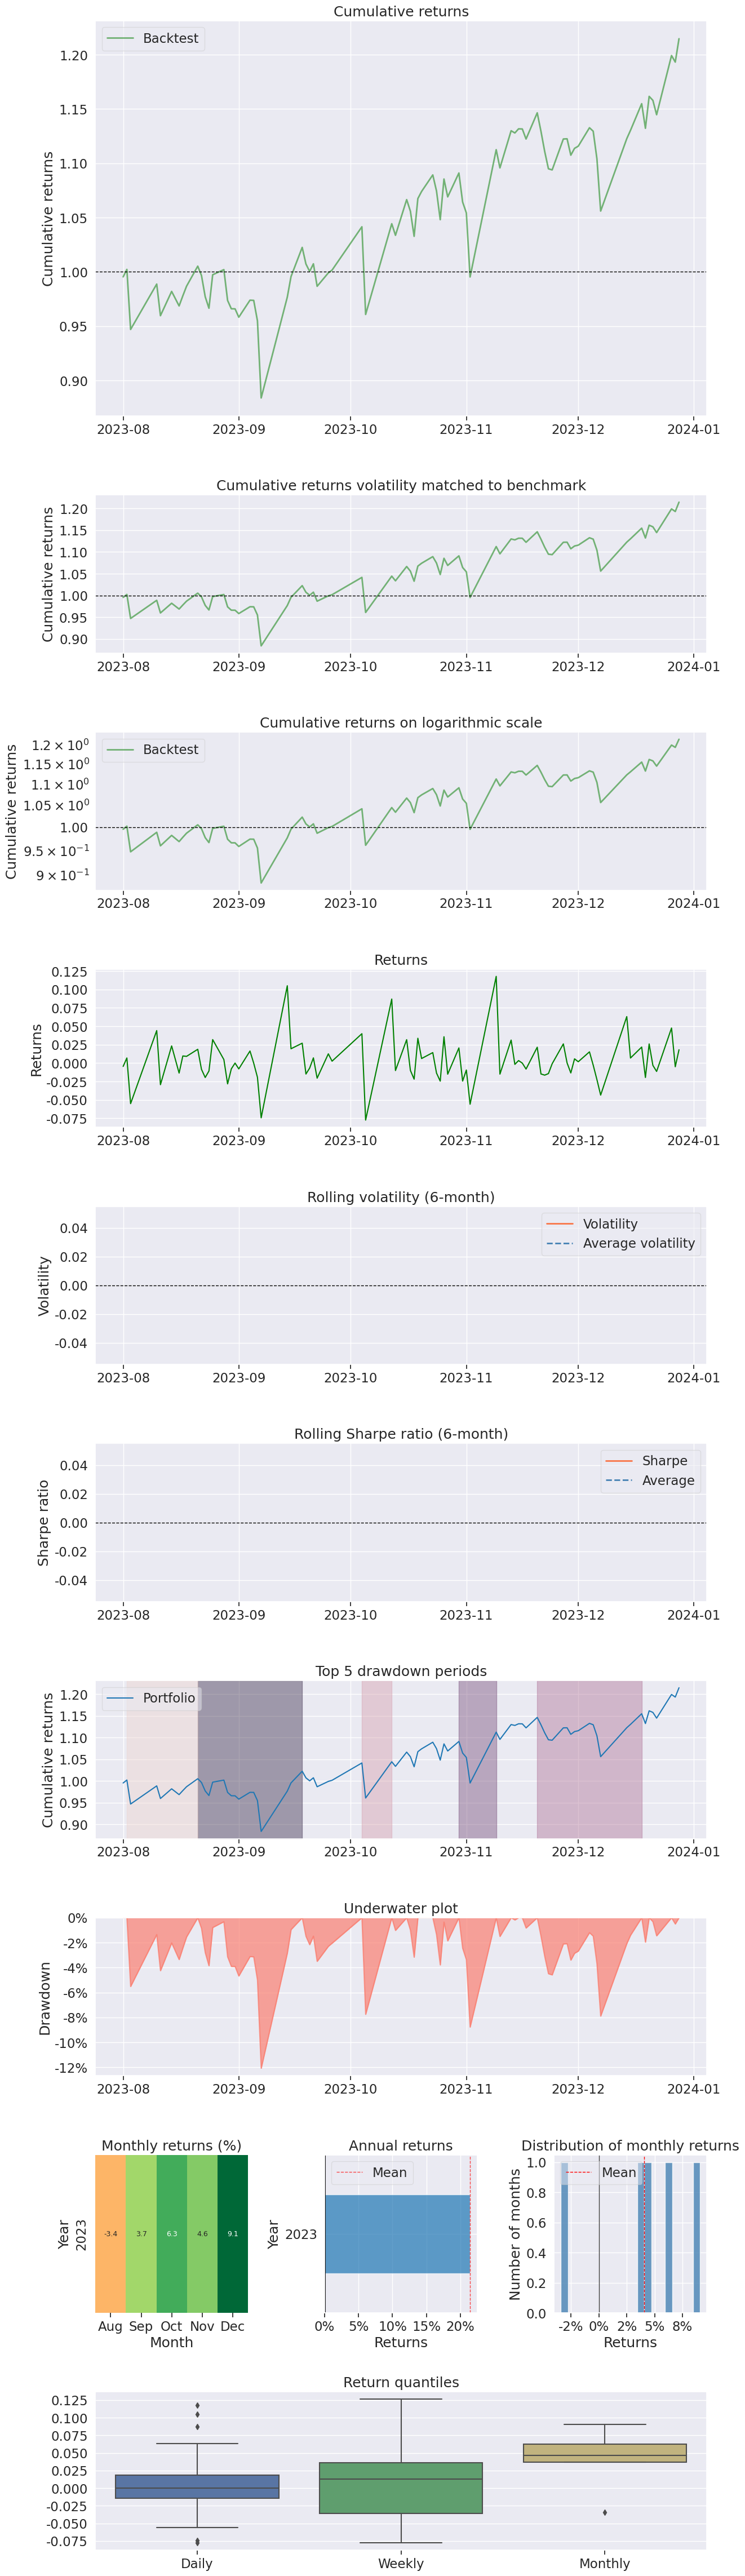

In [ ]:
returns = df[['kospi_returns', 'w_vix_returns', 'vix_returns']]
portfolio_weights = [0.81, 0.19, 0.0]

portfolio_returns = pd.Series(np.dot(portfolio_weights, returns.T),
                              index=df.index)

pf.create_returns_tear_sheet(returns=portfolio_returns)

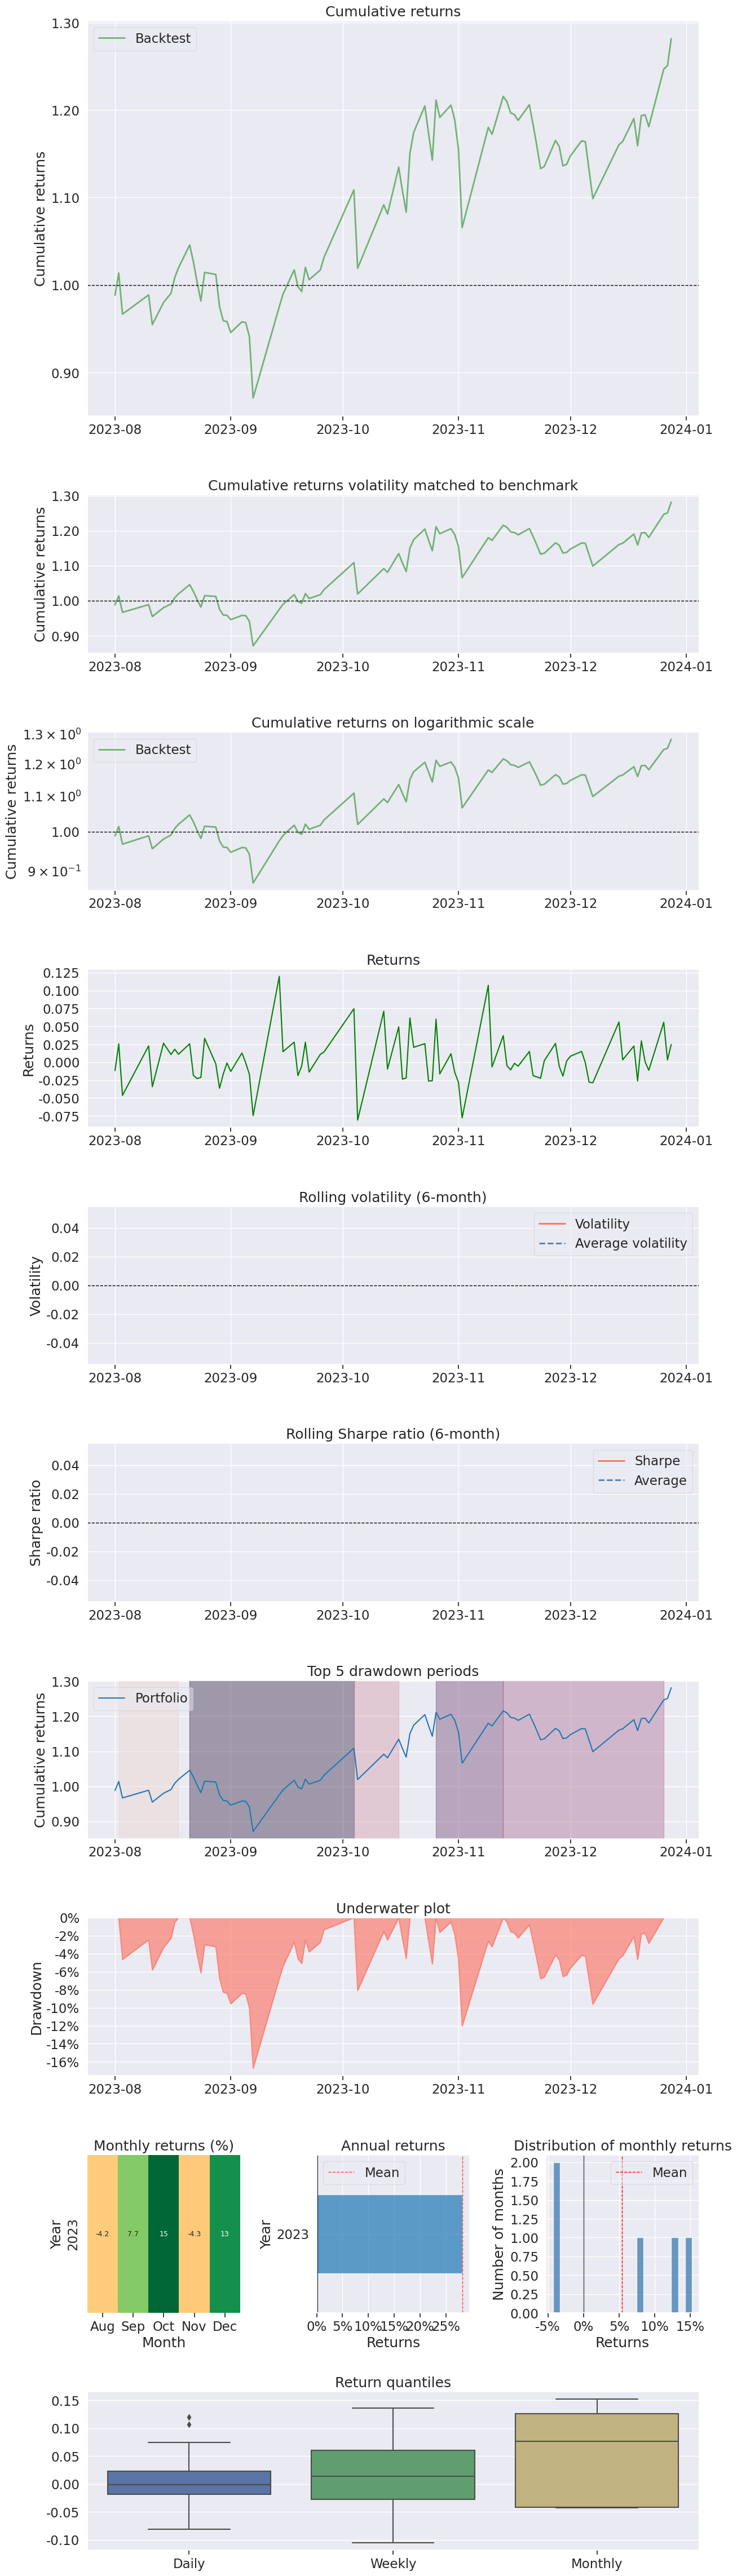

In [ ]:
returns = df[['kospi_returns', 'w_vix_returns', 'vix_returns']]
portfolio_weights = [0.6, 0.2, 0.2]

portfolio_returns = pd.Series(np.dot(portfolio_weights, returns.T),
                              index=df.index)

pf.create_returns_tear_sheet(returns=portfolio_returns)